In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import torch
from torchquad import set_up_backend  # Necessary to enable GPU support
from torchquad import Trapezoid, Simpson, Boole, MonteCarlo, VEGAS, Gaussian, GaussLegendre # The available integrators
import torchquad
import itertools
import math
import matplotlib.pyplot as plt
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
!nvidia-smi

Tue Feb 13 20:06:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A40                     On  | 00000000:17:00.0 Off |                    0 |
|  0%   23C    P8              23W / 300W |      7MiB / 46068MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [18]:
mc=MonteCarlo()
gl=GaussLegendre()
def create_single_sample(p, u_plus, lin_mod):
#creates a single sample according to trigonometric polynomial of degree p (as in paper), 
#lin_mod=True if a linear model for data creation is used
#otherwise it is quadratic, requires to add ground trouth u_+, 
#Output: sampled coeffs, functional sample X, associated scalar output Y
    a = torch.rand(p + 1) * 2 - 1
    X = lambda s: torch.sum(torch.stack([a[i] * torch.cos(torch.tensor(i) * s) for i in range(p + 1)]), dim=0)    
    Y_1 = gl.integrate(lambda t: u_plus[1](t) * X(t),dim=1,N=1000,integration_domain=[[0, 2*math.pi]],backend="torch",)
    if lin_mod:
        Y = Y_1 + u_plus[0]
    else:
        Y_2 = gl.integrate(lambda t: u_plus[2](t)*X(t[:,0])*X(t[:,1]),dim=2,N=1000,integration_domain=[[0, 2*math.pi], [0, 2*math.pi]],
        backend="torch",)
        Y = Y_1 + Y_2 + u_plus[0]
    return a, X, Y

def compute_training_data(p, N, u_plus, lin_mod):
#compute N training samples according to above procedure
#outputs: a: sampled coeffs as tensor of shape Nxp, X: tensor collecting N functional samples, 
#Y: tensor collecting N scalar outputs, covariances between individual inputs
    samples = [create_single_sample(p, u_plus, lin_mod) for i in range(N)]
    a=[]
    X=[]
    Y=[]
    for s in samples:
        a.append(s[0])
        X.append(s[1])
        Y.append(s[2])
    covariances = torch.stack([gl.integrate(lambda t: X[i](t) * X[j](t)
                    ,dim=1,N=1000,integration_domain=[[0, 2*math.pi]],backend="torch",) for i in range(N) for j in range(N)])
    covariances = covariances.reshape((N, N))
    Y=torch.tensor(Y)
    return a, X, Y, covariances

def compute_training_data_list(p, N, u_plus, lin_mod=False):
#compute list collecting training data of sizes i=1,...,N
    train_data_list = []
    for i in range(1, N + 1):
        train_data_list.append(compute_training_data(p, i, u_plus, lin_mod))
    return train_data_list

def compute_coeffs_and_u_lam_single(a, X, Y, covariances, N, u_plus, lam, r, lin_coeffs, lin_mod):
#compute coefficients and associated approximants associated to one-parameter Tikhonov, lam=reg-parameter
#r=number of Tikhonov-iterations, lin_coeffs=True if the associated system for linear PFR (i.e. l=1) should be considered
    if lin_coeffs:
        matrix = torch.stack([torch.sum(torch.stack([covariances[i, j]**l for l in range(2)]), dim=0) 
                                        for i in range(N) for j in range (N)])
    else:
        matrix = torch.stack([torch.sum(torch.stack([covariances[i, j]**l for l in range(3)])) 
                                        for i in range(N) for j in range (N)])
    matrix = matrix.reshape((N, N)) + N * lam * torch.eye(N, N, dtype=torch.float64)
    coeffs = torch.zeros(N,dtype=torch.float64)
    for k in range(r):
        coeffs = torch.linalg.solve(matrix,Y + lam * torch.sum(coeffs,dim=0))
    u_lam_0 = torch.sum(coeffs,dim=0)
    u_lam_1 = lambda t: torch.sum([coeffs[i] * X[i](t) for i in range(N)])
    if lin_mod:
        u_lam = [u_lam_0, u_lam_1]
    else:
        u_lam_2 = lambda t, tau: torch.sum([coeffs[i] * X[i](t) * X[i](tau) for i in range(N)])
        u_lam = [u_lam_0, u_lam_1, u_lam_2]
    return coeffs, u_lam

def compute_coeffs_and_u_lam_multi(a, X, Y, covariances, N, u_plus, lam_0, lam_1, lam_2):
#compute coefficients and associated approximant associated to one-parameter Tikhonov, in case of quardratic PFR
#lam_0, lam_1, lam_2=reg-parameter have to be set beforehand
    matrix = torch.zeros((2 * N + 1, 2 * N + 1), dtype=torch.float64)
    for l in range(1, 3):
        for s in range(N):
            matrix[0, s + (l - 1) * N + 1] = torch.sum(covariances[s, :]**l)
    matrix[0, 0] = N + N * lam_0
    for i in range(N):
        matrix[1 + i, 0] = 1
        for l in range(1, 3):
            for s in range(N):
                matrix[1 + i, s + (l - 1) * N + 1] = covariances[i, s]**l
        matrix[1 + i, 1 + i] = matrix[1 + i, 1 + i] + N * lam_1
    for i in range(N):
        matrix[1 + i + N, 0] = 1
        for l in range(1, 3):
            for s in range(N):
                matrix[1 + i + N, s + (l - 1) * N + 1] = covariances[i, s]**l
        matrix[1 + i + N, 1 + i + N] = matrix[1 + i + N, 1 + i + N] + N * lam_2
    Y_new = torch.zeros(2 * N + 1, dtype=torch.float64)
    Y_new[0] = torch.sum(Y)
    for i in range(N):
        Y_new[i + 1] = Y[i]
        Y_new[N + i + 1] = Y[i]
    coeffs = torch.linalg.solve(matrix,Y_new)
    u_lam_0 = coeffs[0]
    u_lam_1 = lambda t: torch.sum(torch.stack([coeffs[i + 1] * X[i](t) for i in range(N)]),dim=0)
    u_lam_2 = lambda t: torch.sum(torch.stack([coeffs[N + 1 + i] * X[i](t[:,0]) * X[i](t[:,1]) for i in range(N)]),dim=0)
    u_lam = [u_lam_0, u_lam_1, u_lam_2]
    return coeffs, u_lam

def compute_error_single(a, X, Y, covariances, N, u_plus, lam, r, lin_coeffs, lin_mod):
#compute error for given sample in case of one-parameter iterated Tikhonov, linear model for data generation 
#and linear coefficients can be set
    coeffs, u_lam = compute_coeffs_and_u_lam_single(a, X, Y, covariances, N, u_plus, lam, r, lin_coeffs, lin_mod)
    error = (u_plus[0] - u_lam[0])**2 + mc.integrate(lambda t: (u_lam[1](t) - u_plus[1](t))**2,
                                                             dim=1,N=1000,integration_domain=[[0, 2*math.pi]],backend="torch",)
    if not lin_mod:
        error = torch.sqrt(error+gl.integrate(lambda t: (u_lam[2](t) - u_plus[2](t))**2
                                                 ,dim=2,N=1000,integration_domain=[[0, 2*math.pi], [0, 2*math.pi]],backend="torch",))
    return error

def compute_errors_single(train_data_list, p, N, u_plus, lam, r1, r2, lin_coeffs=False, lin_mod=False):
#compute errors for one-parameter Tikhonov associated to different sample sizes i=1,...,N and for different numbers of iterations
    errors1 = []
    errors2 = []
    for i in range(N):
        a, X, Y, covariances = train_data_list[i]
        errors1.append(compute_error_single(a, X, Y, covariances, i + 1, u_plus, lam, r1, lin_coeffs, lin_mod))
        errors2.append(compute_error_single(a, X, Y, covariances, i + 1, u_plus, lam, r2, lin_coeffs, lin_mod))
    return errors1, errors2

def compute_model_and_error_multi(a, X, Y, covariances, N, u_plus, lam_0, lam_1, lam_2):
#compute error for given sample in case of multi parameter Tikhonov regularization
    coeffs, u_lam = compute_coeffs_and_u_lam_multi(a, X, Y, covariances, N, u_plus, lam_0, lam_1, lam_2)
    error = (u_plus[0] - u_lam[0])**2 + gl.integrate(lambda t: (u_lam[1](t) - u_plus[1](t))**2,
                                                             dim=1,N=1000,integration_domain=[[0, 2*math.pi]],backend="torch",)
    error = torch.sqrt(error+gl.integrate(lambda t: (u_lam[2](t) - u_plus[2](t))**2,
                                             dim=2,N=1000,integration_domain=[[0, 2*math.pi], [0, 2*math.pi]],backend="torch",))
    return u_lam, error

def compute_models_and_errors_multi(p, N, u_plus, lam_values_list):
#compute errors for multi-parameter Tikhonov associated to different sample sizes i=1,...,N 
#and different choices of tensor [lam_0,lam_1,lam_2]

    train_data_list = compute_training_data_list(p, N, u_plus)
    errors = {}
    model_list={}
    for i in range(N):
        model_list[i]=[]
        
    for lam in lam_values_list:
        errors_lam = []
        for i in range(N):
            a, X, Y, covariances = train_data_list[i]
            model,error=compute_model_and_error_multi(a, X, Y, covariances, i + 1, u_plus, lam[0], lam[1], lam[2])
            model_list[i].append(model)
            errors_lam.append(error)
        errors["lam_0={lam_0}, lam_1={lam_1}, lam_2={lam_2}".format(lam_0=lam[0], lam_1=lam[1], lam_2=lam[2])] = torch.tensor(errors_lam)
    return model_list, errors

def compute_Au(u,X):
#for given model u and input X compute Au as in formula (3)
    Au_0=u[0]
    Au_1=gl.integrate(lambda t: u[1](t) * X(t),dim=1,N=1000,integration_domain=[[0, 2*math.pi]],backend="torch",)
    Au_2=gl.integrate(lambda t: u[2](t)*X(t[:,0])*X(t[:,1]),dim=2,N=1000,integration_domain=[[0, 2*math.pi], [0, 2*math.pi]],
        backend="torch",)
    return Au_0+Au_1+Au_2


def compute_G_and_g(model_list,X,Y):
#for given list of models and given input samples X and outputs Y, compute Gram matrix tG and vector tg according to (25)--(26)
    R=len(model_list)
    N=len(X)
    Au_list={}
    for i in range(N):
        for r in range(R):
            Au_list[r,i]=compute_Au(model_list[r],X[i])
    G=torch.stack([torch.mean(torch.stack([Au_list[r,i]*Au_list[s,i] for i in range(N)]), dim=0) for r in range(R) for s in range(R)])
    g=torch.stack([torch.mean(torch.stack([Au_list[r,i]*Y[i] for i in range(N)]), dim=0) for r in range(R)])
    G=G.reshape(R,R)
    return g,G

def compute_aggregation(model_list,X,Y):
#for given list of models and given input samples X and outputs Y, compute associated aggregation model u_agg
    R=len(model_list)
    g,G=compute_G_and_g(model_list,X,Y)
    coeffs=torch.linalg.solve(G,g)
    u_agg=[torch.sum(torch.stack([coeffs[r]*model_list[r][0] for r in range(R)])), 
               lambda t: torch.sum(torch.stack([coeffs[r] * model_list[r][1](t) for r in range(R)]), dim=0),
               lambda t: torch.sum(torch.stack([coeffs[r] * model_list[r][2](t) for r in range(R)]), dim=0)]
    return u_agg

def compute_error_agg(model_list,X,Y,u_plus):
#for given list of models, input samples X, outputs Y and ground truth u^+ compute error u_agg-u^+
    u_agg=compute_aggregation(model_list,X,Y)
    error = (u_plus[0] - u_agg[0])**2 + gl.integrate(lambda t: (u_agg[1](t) - u_plus[1](t))**2,
                                                             dim=1,N=1000,integration_domain=[[0, 2*math.pi]],backend="torch",)
    error = torch.sqrt(error+gl.integrate(lambda t: (u_agg[2](t) - u_plus[2](t))**2,
                                             dim=2,N=1000,integration_domain=[[0, 2*math.pi], [0, 2*math.pi]],backend="torch",))
    return error

def compute_errors_agg(model_lists,p,M,u_plus):
    errors=[]
    N=len(model_lists)
    a,X,Y,cov=compute_training_data(p, M, u_plus, lin_mod=False)
    for i in range(N):
        errors.append(compute_error_agg(model_lists[i],X,Y,u_plus))
    errors=torch.tensor(errors)
    return errors


/system/user/holzleit/Conda/conda0/lib/python3.11/site-packages/autoray/autoray.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return get_lib_fn(backend, fn)(*args, **kwargs)
/system/user/holzleit/Conda/conda0/lib/python3.11/site-packages/torchquad/integration/utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


{'lam_0=1e-05, lam_1=1e-05, lam_2=1e-05': tensor([9.3860, 9.6266, 9.0016, 9.1851, 9.0102, 8.9433, 8.7262, 8.6216, 7.4342,
        8.2181, 7.0088, 8.2226, 6.6861, 6.0738, 7.4017, 6.1739, 7.0887, 7.6162,
        7.2616, 5.9522, 5.5680, 4.4952, 3.9326, 4.8202, 4.8072, 3.8117, 3.1567,
        3.1416, 3.1469, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416,
        3.1416, 3.1416, 3.1416, 3.1416]), 'lam_0=1e-05, lam_1=1e-05, lam_2=1e-07': tensor([ 9.4847,  9.6799,  9.9316,  9.8031,  9.8046,  9.5820,  9.9351,  9.9765,
        12.8232, 10.3807, 16.7761, 16.0975, 10.6026, 17.8839, 12.0942, 17.6980,
        11.6524, 10.7326, 22.0335, 17.8914, 13.6305, 16.8512, 15.7155,  7.6783,
        10.4858,  8.9559,  3.1457,  3.1416,  3.1457,  3.1416,  3.1416,  3.1416,
         3.1416,  3.1416,  3.1416,  3.1416,  3.1416,  3.1416,  3.1416,  3.1416]), 'lam_0=1e-05, lam_1=1e-05, lam_2=1e-09': tensor([ 9.4863,  9.6806,  9.9490,  9.8103,  9.8205,  9.5893,  9.9647,  9.9975,
        13.0379, 10.4177, 17.932

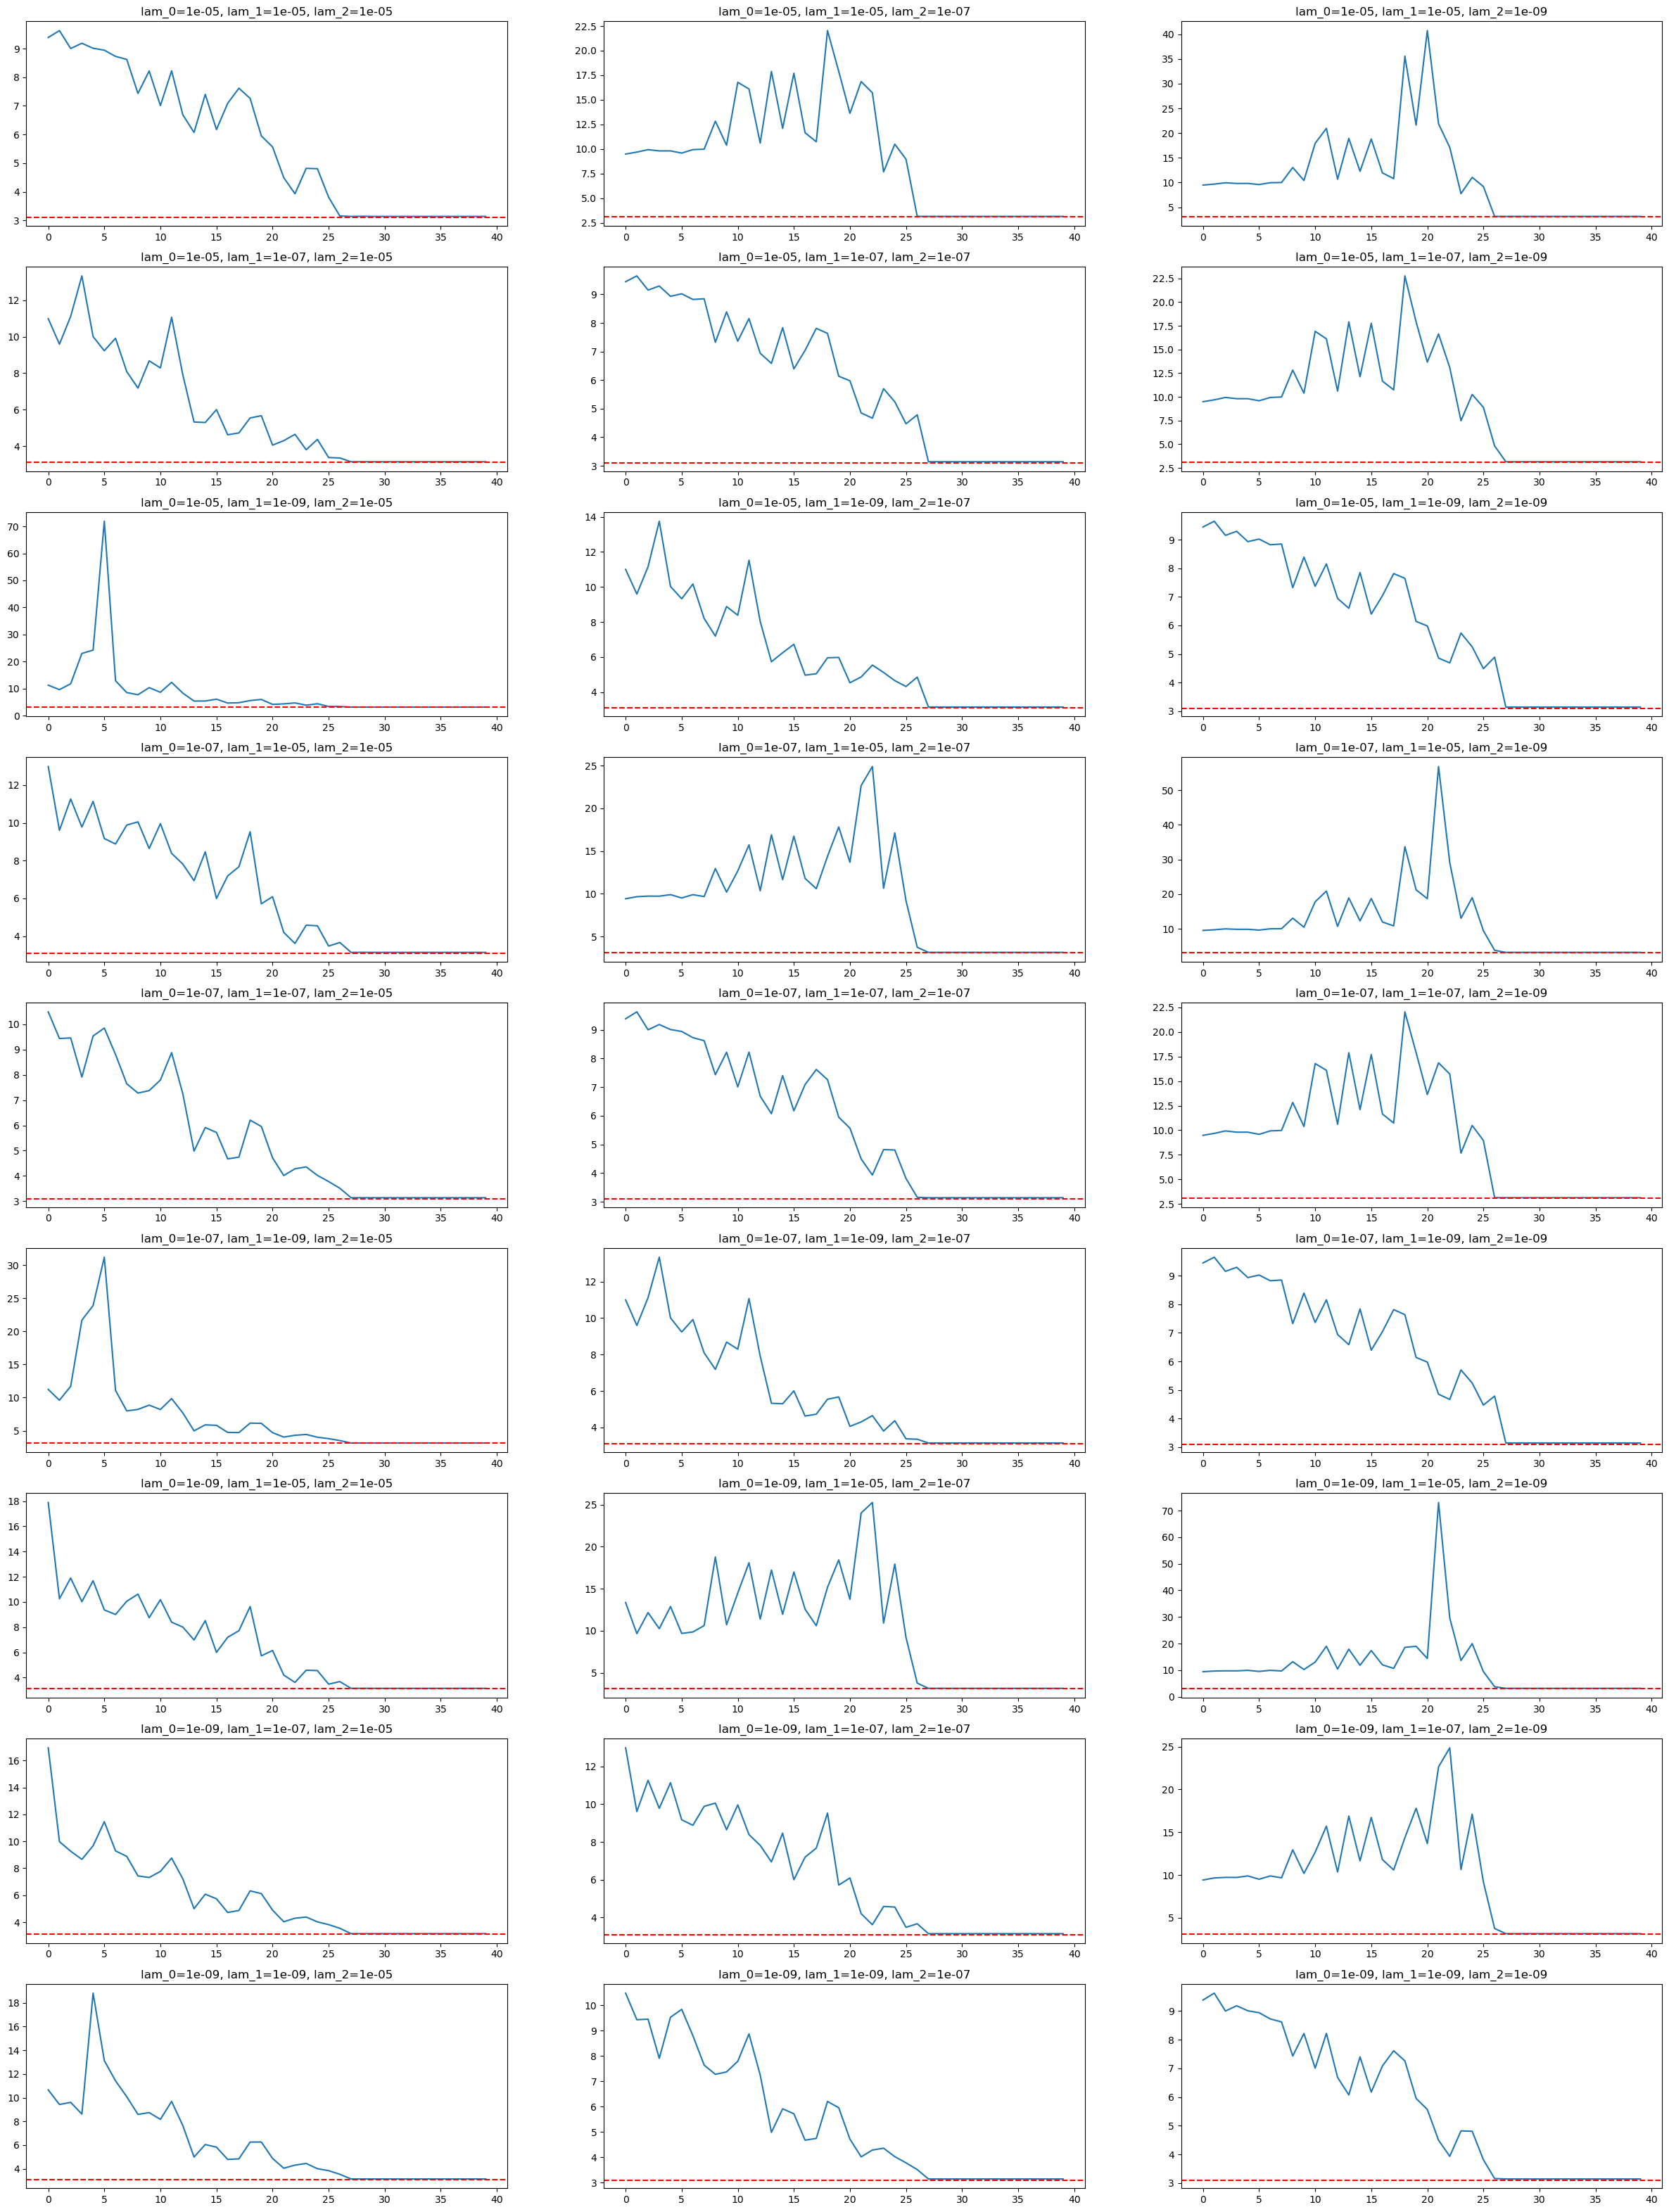

In [23]:
set_up_backend("torch", data_type="float64")
u_plus = [2,
    lambda t: 1 + 4*torch.cos(t) + torch.cos(5 * t),
    lambda t: torch.cos(3 * t[:,0]) + torch.cos(2 * t[:,1])*torch.cos(2.0 * t[:,0])]

#train_data_list = compute_training_data_list(5, 40, u_plus)
lam_values_list = list(itertools.product([1e-5, 1e-7, 1e-9], repeat=3))

model_list, errors_multi = compute_models_and_errors_multi(5, 40, u_plus, lam_values_list)

print(errors_multi)

#print(model_list)

fig = plt.figure(figsize=(30, 40))
for i, lam_list in enumerate(errors_multi.keys()):
    plt.subplot(9, 3, i + 1)
    plt.plot(range(40),errors_multi[lam_list].cpu())
    plt.axhline(y=3.1, color='r', linestyle='--')
    plt.title(lam_list)

plt.show()
fig.savefig('Multiparameter.pdf')

/system/user/holzleit/Conda/conda0/lib/python3.11/site-packages/autoray/autoray.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return get_lib_fn(backend, fn)(*args, **kwargs)
/system/user/holzleit/Conda/conda0/lib/python3.11/site-packages/torchquad/integration/utils.py:255: UserWarning: DEPRECATION WARNING: In future versions of torchquad, an array-like object will be returned.
  warnings.warn(


tensor([9.4565, 9.6580, 6.0230, 6.6206, 6.0466, 7.6362, 8.3398, 7.0797, 6.1285,
        5.9245, 3.4954, 5.3859, 5.2769, 5.2667, 4.4953, 5.5319, 5.3505, 5.5378,
        4.2514, 3.2134, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416,
        3.1416, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416, 3.1416,
        3.1416, 3.1416, 3.1416, 3.1416])


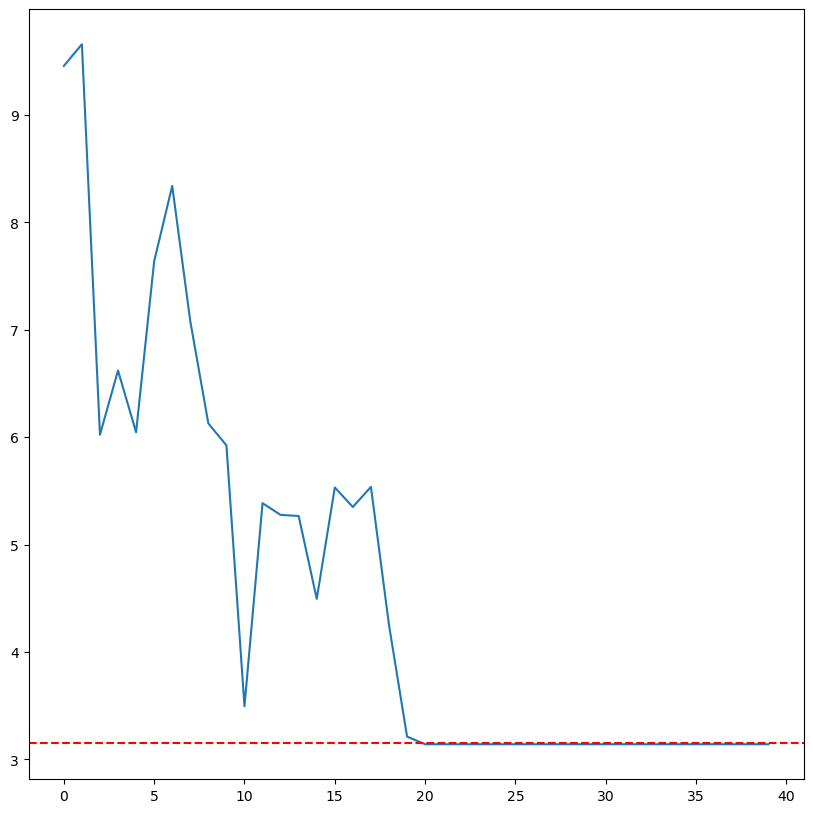

In [24]:
errors_agg=compute_errors_agg(model_list,5,40,u_plus)
print(errors_agg)
fig_agg=plt.figure(figsize=(10, 10))

plt.plot(range(40),errors_agg.cpu())
plt.axhline(y=3.15, color='r', linestyle='--', label='error=3.14')
plt.show()
fig_agg.savefig('agg.pdf')

In [6]:
a,X,Y,cov=compute_training_data(5, 50, u_plus, lin_mod=False)
print(compute_error_agg(model_list[39],X,Y,u_plus))

tensor(3.1416)
